# Dynamic ecoregions

## Define inputs

In [105]:
# Inputs
input_file = "data/data-new-york-city.txt"
geohash_precision = 4
log_file = "run.log"
output_file = "output.geojson"
num_clusters = 2
use_cache = False
plot = True

## Set up logging

In [106]:
import logging

logging.basicConfig(filename=log_file, encoding="utf-8", level=logging.INFO)

## Data flow

```mermaid
flowchart
    DarwinCoreCsvLazyFrame --> TaxonomyDataFrame
    DarwinCoreCsvLazyFrame --> GeohashSpeciesCountsDataFrame
    GeohashSpeciesCountsDataFrame --> DistanceMatrix
    GeohashSpeciesCountsDataFrame --> GeohashClusterDataFrame
    DistanceMatrix --> GeohashClusterDataFrame
    GeohashClusterDataFrame --> ClusterColorDataFrame
    GeohashSpeciesCountsDataFrame --> ClusterTaxaStatisticsDataFrame
    GeohashClusterDataFrame --> ClusterTaxaStatisticsDataFrame
    TaxonomyDataFrame --> ClusterTaxaStatisticsDataFrame
```

## `DarwinCoreCsvLazyFrame`

### Build

In [107]:
from src.lazyframes.darwin_core_csv import DarwinCoreCsvLazyFrame

darwin_core_csv_lazy_frame = DarwinCoreCsvLazyFrame.from_file(input_file)

### Preview

In [108]:
darwin_core_csv_lazy_frame.lf.limit(3).collect()

gbifID,accessRights,bibliographicCitation,language,license,modified,publisher,references,rightsHolder,type,institutionID,collectionID,datasetID,institutionCode,collectionCode,datasetName,ownerInstitutionCode,basisOfRecord,informationWithheld,dataGeneralizations,dynamicProperties,occurrenceID,catalogNumber,recordNumber,recordedBy,recordedByID,individualCount,organismQuantity,organismQuantityType,sex,lifeStage,reproductiveCondition,caste,behavior,vitality,establishmentMeans,degreeOfEstablishment,…,distanceFromCentroidInMeters,issue,mediaType,hasCoordinate,hasGeospatialIssues,taxonKey,acceptedTaxonKey,kingdomKey,phylumKey,classKey,orderKey,familyKey,genusKey,subgenusKey,speciesKey,species,acceptedScientificName,verbatimScientificName,typifiedName,protocol,lastParsed,lastCrawled,repatriated,relativeOrganismQuantity,projectId,isSequenced,gbifRegion,publishedByGbifRegion,level0Gid,level0Name,level1Gid,level1Name,level2Gid,level2Name,level3Gid,level3Name,iucnRedListCategory
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,u64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""3873630669""",null,null,null,"""CC_BY_NC_4_0""","""2022-07-17T19:18:35Z""","""iNaturalist.org""","""https://www.inaturalist.org/ob…","""Susan J. Hewitt""",null,null,null,null,"""iNaturalist""","""Observations""","""iNaturalist research-grade obs…",null,"""HUMAN_OBSERVATION""",null,null,null,"""https://www.inaturalist.org/ob…","""126532255""",null,"""Susan J. Hewitt""",null,null,null,null,null,null,null,null,null,null,null,null,…,null,"""COORDINATE_ROUNDED;CONTINENT_D…","""StillImage""","""true""","""false""",3120946,"""3120946""","""6""","""7707728""","""220""","""414""","""3065""","""3120641""",null,"""3120946""","""Artemisia vulgaris""","""Artemisia vulgaris L.""","""Artemisia vulgaris""",null,"""DWC_ARCHIVE""","""2024-11-25T07:11:55.041Z""","""2024-11-24T12:50:10.745Z""","""false""",null,"""null""","""false""","""NORTH_AMERICA""","""NORTH_AMERICA""","""USA""","""United States""","""USA.33_1""","""New York""","""USA.33.32_1""","""New York""",null,null,"""NE"""
"""1500300889""",null,null,null,"""CC_BY_NC_4_0""","""2020-07-01T14:20:17Z""","""iNaturalist.org""","""https://www.inaturalist.org/ob…","""Tan Kok Hui""",null,null,null,null,"""iNaturalist""","""Observations""","""iNaturalist research-grade obs…",null,"""HUMAN_OBSERVATION""",null,null,null,"""https://www.inaturalist.org/ob…","""5916697""",null,"""Tan Kok Hui""",null,null,null,null,null,"""Juvenile""",null,null,null,null,null,null,…,null,"""CONTINENT_DERIVED_FROM_COORDIN…","""StillImage""","""true""","""false""",2481134,"""2481134""","""1""","""44""","""212""","""7192402""","""9316""","""2481126""",null,"""2481134""","""Larus delawarensis""","""Larus delawarensis Ord, 1815""","""Larus delawarensis""",null,"""DWC_ARCHIVE""","""2024-11-25T06:59:47.147Z""","""2024-11-24T12:50:10.745Z""","""false""",null,"""null""","""false""","""NORTH_AMERICA""","""NORTH_AMERICA""","""USA""","""United States""","""USA.33_1""","""New York""","""USA.33.32_1""","""New York""",null,null,"""LC"""
"""1640074334""",null,null,null,"""CC_BY_NC_4_0""","""2017-09-01T22:58:42Z""","""iNaturalist.org""","""https://www.inaturalist.org/ob…","""Priyantha Wijesinghe""",null,null,null,null,"""iNaturalist""","""Observations""","""iNaturalist research-grade obs…",null,"""HUMAN_OBSERVATION""",null,null,null,"""https://www.inaturalist.org/ob…","""7721017""",null,"""Priyantha Wijesinghe""",null,null,null,null,null,"""Adult""",null,null,null,null,null,null,…,null,"""COORDINATE_ROUNDED;CONTINENT_D…","""StillImage;StillImage""","""true""","""false""",1991429,"""1991429""","""1""","""54""","""216""","""797""","""6950""","""1991426""",null,"""1991429""","""Haematopis grataria""","""Haematopis grataria (Fabricius…","""Haematopis grataria""",null,"""DWC_ARCHIVE"

## `TaxonomyDataFrame`

### Build

In [109]:
from src.dataframes.taxonomy import TaxonomyDataFrame

taxonomy_dataframe = TaxonomyDataFrame.build(darwin_core_csv_lazy_frame)

### Preview

In [110]:
taxonomy_dataframe.df.limit(3)

kingdom,phylum,class,order,family,genus,species
enum,str,str,str,str,str,str
"""Plantae""","""Tracheophyta""","""Magnoliopsida""","""Rosales""","""Rosaceae""","""Chaenomeles""","""Chaenomeles speciosa"""
"""Animalia""","""Chordata""","""Aves""","""Psittaciformes""","""Psittacidae""","""Nymphicus""","""Nymphicus hollandicus"""
"""Plantae""","""Tracheophyta""","""Magnoliopsida""","""Cornales""","""Hydrangeaceae""","""Hydrangea""","""Hydrangea petiolaris"""


## `GeohashSpeciesCountsDataFrame`

### Build

In [111]:
from src.dataframes.geohash_species_counts import GeohashSpeciesCountsDataFrame

geohash_taxa_counts_dataframe = GeohashSpeciesCountsDataFrame.build(
    darwin_core_csv_lazy_frame, geohash_precision
)

### Preview

In [112]:
geohash_taxa_counts_dataframe.df.limit(3)

geohash,kingdom,rank,name,count
str,enum,enum,str,u32
"""dr5n""","""Fungi""","""species""","""Trametopsis cervina""",1
"""dr5n""","""Fungi""","""species""","""Berkleasmium conglobatum""",3
"""dr5n""","""Fungi""","""species""","""Trametes lactinea""",4


## `DistanceMatrix`

### Build

In [113]:
from src.distance_matrix import DistanceMatrix

distance_matrix = DistanceMatrix.build(
    geohash_taxa_counts_dataframe,
    use_cache,
)

/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions-experiments/.venv/lib/python3.13/site-packages/sklearn/decomposition/_incremental_pca.py:376: RuntimeWarning: Mean of empty slice.
  self.noise_variance_ = explained_variance[self.n_components_ :].mean()
/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions-experiments/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


### Preview

In [114]:
distance_matrix.squareform()

array([[0.        , 0.29330395, 0.95276014, 1.28066247, 0.30042134,
        0.91285869, 0.858189  , 0.3055708 ],
       [0.29330395, 0.        , 0.96295519, 1.29216131, 0.06198735,
        0.88606188, 0.82980449, 0.22149642],
       [0.95276014, 0.96295519, 0.        , 1.21733599, 0.95490991,
        0.73940123, 0.90884742, 0.97587808],
       [1.28066247, 1.29216131, 1.21733599, 0.        , 1.29198495,
        1.21984108, 1.18942302, 1.2785143 ],
       [0.30042134, 0.06198735, 0.95490991, 1.29198495, 0.        ,
        0.8885703 , 0.83511096, 0.23158026],
       [0.91285869, 0.88606188, 0.73940123, 1.21984108, 0.8885703 ,
        0.        , 0.78699397, 0.89272306],
       [0.858189  , 0.82980449, 0.90884742, 1.18942302, 0.83511096,
        0.78699397, 0.        , 0.83156345],
       [0.3055708 , 0.22149642, 0.97587808, 1.2785143 , 0.23158026,
        0.89272306, 0.83156345, 0.        ]])

## `GeohashClusterDataFrame`

### Build

In [115]:
from src.dataframes.geohash_cluster import GeohashClusterDataFrame

geohash_cluster_dataframe = GeohashClusterDataFrame.build(
    geohash_taxa_counts_dataframe,
    distance_matrix,
    num_clusters,
)

### Preview

In [116]:
geohash_cluster_dataframe.df.limit(3)

geohash,cluster
str,u32
"""dr5n""",1
"""dr5p""",1
"""dr5q""",2


## `ClusterColorDataFrame`

### Build

In [117]:
from src.dataframes.cluster_color import ClusterColorDataFrame

cluster_colors_dataframe = ClusterColorDataFrame.from_clusters(geohash_cluster_dataframe)

### Preview

In [118]:
cluster_colors_dataframe.df.limit(3)

cluster,color
u32,str
1,"""#fdbe6e"""
2,"""#bee5a0"""


## `ClusterTaxaStatisticsDataFrame`

### Build

In [119]:
from src.dataframes.cluster_taxa_statistics import ClusterTaxaStatisticsDataFrame

cluster_taxa_statistics_dataframe = ClusterTaxaStatisticsDataFrame.build(
    geohash_taxa_counts_dataframe,
    geohash_cluster_dataframe,
    taxonomy_dataframe,
)

### Preview

In [120]:
cluster_taxa_statistics_dataframe.df.limit(3)

cluster,kingdom,rank,name,count,average
u32,enum,enum,str,u32,f64
null,"""Bacteria""","""phylum""","""Cyanobacteria""",11,0.000021
null,"""Animalia""","""phylum""","""Annelida""",38,0.000073
null,"""Animalia""","""phylum""","""Arthropoda""",128218,0.245943


## `ClusterSignificantDifferencesDataFrame`

### Build

In [121]:
from src.dataframes.cluster_significant_differences import ClusterSignificantDifferencesDataFrame

cluster_significant_differences_dataframe = ClusterSignificantDifferencesDataFrame.build(
    cluster_taxa_statistics_dataframe,
)

/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions-experiments/src/dataframes/cluster_significant_differences.py:33: UserWarning: Comparisons with None always result in null. Consider using `.is_null()` or `.is_not_null()`.
  pl.col("cluster") == cluster,


### Preview

In [122]:
cluster_significant_differences_dataframe.df.limit(3)

cluster,taxon,percentage_difference
u32,str,f64
1,"""Ageratina altissima""",122.817687
1,"""Celastrus orbiculatus""",528.529985
1,"""Artemisia vulgaris""",-40.734531


## Build and plot GeoJSON feature collection

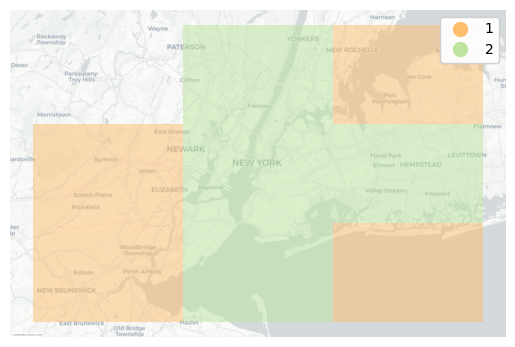

In [123]:
from src.geojson import build_geojson_feature_collection, write_geojson
from src.render import plot_clusters

feature_collection = build_geojson_feature_collection(
    geohash_cluster_dataframe,
    cluster_colors_dataframe,
)

# print_results(darwin_core_aggregations, all_stats, cluster_dataframe)

write_geojson(feature_collection, output_file)

plot_clusters(feature_collection)

# write_geojson(feature_collection, args.output_file)

# Build and display HTML output

In [124]:
from src.html_output import build_html_output
from IPython.display import display, HTML

html = build_html_output(
    cluster_colors_dataframe,
    cluster_significant_differences_dataframe,
)

display(HTML(html))


In [128]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    random_state=42,
    metric="precomputed",
    init="random",
    perplexity=min(30, distance_matrix.squareform().shape[0] - 1), # HACK FOR SMALLER DATASETS
)
X_tsne = tsne.fit_transform(distance_matrix.squareform())
tsne.kl_divergence_


0.19873395562171936

<Axes: >

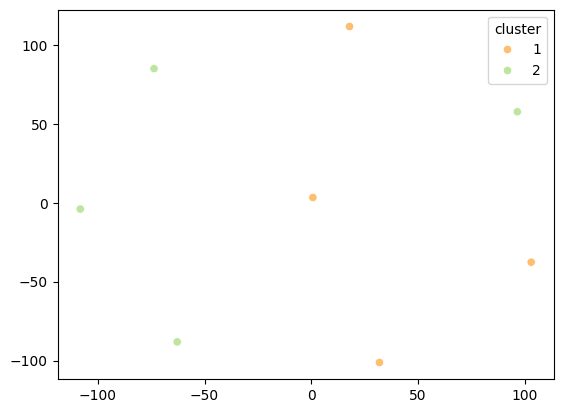

In [129]:
import seaborn as sns

sns.scatterplot(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue=geohash_cluster_dataframe.df["cluster"],
    palette=cluster_colors_dataframe.to_dict(),
    alpha=1,
)

In [134]:
import seaborn as sns
import matplotlib.pyplot as plt
import polars as pl
from scipy.cluster.hierarchy import linkage

from src.darwin_core import TaxonRank

linkage_array = linkage(distance_matrix.condensed(), "ward")

ordered_geohashes = geohash_taxa_counts_dataframe.ordered_geohashes()

def min_max_normalize(series: pl.Series) -> pl.Series:
    return (series - series.min()) / (series.max() - series.min())

col_colors = []
for geohash in ordered_geohashes:
    cluster = geohash_cluster_dataframe.cluster_for_geohash(geohash)
    col_colors.append(cluster_colors_dataframe.get_color_for_cluster(cluster))

data = {}
for species in cluster_significant_differences_dataframe.df["taxon"].unique():
    counts = []

    for geohash in ordered_geohashes:
        geohash_counts_species = geohash_taxa_counts_dataframe.df.filter(
            pl.col("geohash") == geohash, pl.col("name") == species
        ).get_column("count").sum()
        geohash_counts_all = geohash_taxa_counts_dataframe.df.filter(
            pl.col("geohash") == geohash
        ).get_column("count").sum()
        geohash_average = geohash_counts_species / geohash_counts_all
        all_average = (
            cluster_taxa_statistics_dataframe.df.filter(
                # pl.col("kingdom") == kingdom, FIXME
                pl.col("name") == species,
                pl.col("cluster").is_null(),
                pl.col("rank") == TaxonRank.species,
            )
            .get_column("average")
            .item()
        )
        counts.append(geohash_average - all_average)
    counts = pl.Series(
        values=counts,
        name=species,
    )
    # counts = counts / counts.max()
    # counts = counts.pow(1 / 3)
    data[species] = min_max_normalize(counts)


In [135]:
data

{'Ardea alba': shape: (8,)
 Series: 'Ardea alba' [f64]
 [
 	0.221755
 	0.246999
 	0.335748
 	0.081316
 	0.341252
 	0.02808
 	0.0
 	1.0
 ],
 'Phragmites australis': shape: (8,)
 Series: 'Phragmites australis' [f64]
 [
 	0.303263
 	1.0
 	0.099425
 	0.0
 	0.187292
 	0.237367
 	0.027598
 	0.208688
 ],
 'Toxicodendron radicans': shape: (8,)
 Series: 'Toxicodendron radicans' [f64]
 [
 	0.649077
 	0.159827
 	0.232463
 	0.0
 	0.400479
 	0.888525
 	0.467116
 	1.0
 ],
 'Lycorma delicatula': shape: (8,)
 Series: 'Lycorma delicatula' [f64]
 [
 	0.246616
 	0.0
 	0.321267
 	1.0
 	0.285928
 	0.38861
 	0.924553
 	0.379267
 ],
 'Alliaria petiolata': shape: (8,)
 Series: 'Alliaria petiolata' [f64]
 [
 	0.59522
 	0.0
 	0.467299
 	0.264815
 	0.193372
 	0.670122
 	0.948037
 	1.0
 ],
 'Liquidambar styraciflua': shape: (8,)
 Series: 'Liquidambar styraciflua' [f64]
 [
 	0.047183
 	1.0
 	0.022851
 	0.00257
 	0.0
 	0.047949
 	0.020468
 	0.032174
 ],
 'Limulus polyphemus': shape: (8,)
 Series: 'Limulus polyphemu

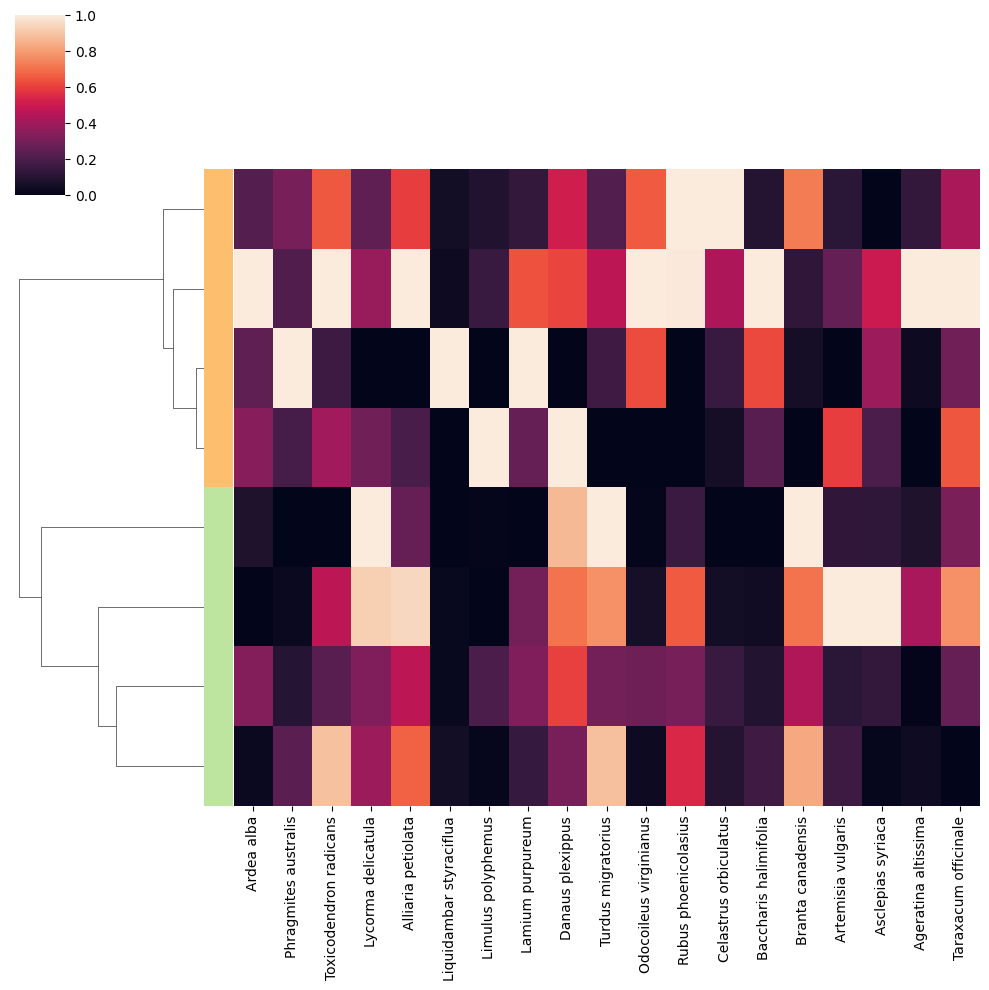

In [136]:
dataframe = pl.DataFrame(data=data)
sns.clustermap(
    data=dataframe,
    col_cluster=False,
    row_cluster=True,
    row_linkage=linkage_array,
    row_colors=col_colors,
    xticklabels=dataframe.columns,
    yticklabels=False,
)